# Prevalencia

Vamos a analizar el influjo de la prevalencia, en el devenir de la enfermedad

<div class="alert alert-block alert-info">
En epidemiología, se denomina <strong>prevalencia</strong> a la proporción de individuos de un grupo o una población (en medicina, persona), que presentan una característica o evento determinado (en medicina, enfermedades).    
</div>

Se define <strong>R0</strong>, como el nº de personas que infecta cada persona, en cada ciclo de infección.

<div class="alert alert-block alert-info">
Vamos a generar una lista de tablasy gráficas para ver la evolución del nº de infectados, al variar la prevalencia, y el R0.
</div>


In [1]:
import numpy as np
import pandas as pd 
import time
from datetime import datetime, date, time, timedelta
from IPython.display import display, HTML
import matplotlib.dates as mdates

SITUACION_INICIAL = 1
prevalencia = 0 
R0 = 5.7
DIAS_EN_REINFECTAR=5


In [2]:
### Calculamos la capacidad del sistema sanitario.
####Cuanto se tardaria en copar las camas de uci en cada escenario
"""
"Antes de la crisis sanitaria, España disponía de unas 4.500 camas UCI, capacidad que aumentó hasta las 8.000"
Madrid cuenta con 1.750 camas
Cataluña tiene 1.722 camas
Andalucía con 1.200 camas.
Canarias cuenta con 595 camas.
Euskadi con capacidad para 550 camas. 
Castilla-León tiene 500 camas.
Aragón con 300 camas.
Castilla-La Mancha cuenta con 300 camas.
Galicia tiene 274 camas.
Comunidad Valenciana con 254 plazas libres.
Navarra con 156 camas. 
Murcia tiene 123 camas. 
Baleares con 120 camas.
Extremadura cuenta con 100 camas.
Cantabria con 64 camas.
Asturias cuenta con 61 camas. 
La Rioja tiene 23 plazas. 
TOTAL = 8092
"""

"De los 11.424 pacientes de Covid-19 ingresados en Madrid, según datos del Ministerio de Sanidad, 1.332 están en la UCI, un 11,7%."
"Si para una prevalencia de 10% (750000 personas para la comunidad de madrid)"

# Calculamos la capacidad del sistema sanitario - el nº de enfermos que puede haber antes de que colapse
NUMERO_CAMAS_UCI=8092 

PORCENTAJE_ENFERMOS_NECESITADOS_HOSPITALIZACION = 0.088 # https://www.redaccionmedica.com/secciones/sanidad-hoy/coronavirus-en-personal-sanitario-hospitalizacion-en-el-8-8-de-casos-9925
PORCENTAJE_HOSPITALIZADOS_NECESITADOS_UCI = 0.05  #https://www.elperiodico.com/es/sociedad/20200316/coronavirus-hospitalizados-graves-contagio-7891866

CAPACIDAD_SISTEMA_SANITARIO = NUMERO_CAMAS_UCI / PORCENTAJE_ENFERMOS_NECESITADOS_HOSPITALIZACION / PORCENTAJE_HOSPITALIZADOS_NECESITADOS_UCI
CAPACIDAD_SISTEMA_SANITARIO = int(CAPACIDAD_SISTEMA_SANITARIO)

print ("La estimacion de la capacidad del sistema sanitario es " , CAPACIDAD_SISTEMA_SANITARIO ) 


La estimacion de la capacidad del sistema sanitario es  1839090


In [3]:
def Get_Header(GENERACIONES,df,FECHA_INICIAL_STR = '2020-02-01'):
    array_fechas = []
    FECHA_INICIAL = datetime.strptime(FECHA_INICIAL_STR, "%Y-%m-%d")
    modified_date = FECHA_INICIAL
    NUM_GENERACIONES = range(1,GENERACIONES)
    for generacion in NUM_GENERACIONES:
        modified_date += timedelta(days=DIAS_EN_REINFECTAR)
        array_fechas.append(datetime.strftime(modified_date, "%Y-%m-%d"))
    df.columns = array_fechas
    return df

def Calcular_Cuadro_Prevalencias(R0,GENERACIONES,ARRAY_PREVALENCIAS, SITUACION_INICIAL=1,FECHA_INICIAL_STR = '2020-02-01'):
    diccionario_prevalencias = {}
    array=[]

    for prevalencia in ARRAY_PREVALENCIAS : 
        infectados_en_esta_generacion = SITUACION_INICIAL
        NUM_GENERACIONES = range(1,GENERACIONES)
        array=[]
        for generacion in NUM_GENERACIONES:
            prevalencia_esta_iteracion =  min(45000000,np.sum(array)) / 45000000
            #print ("infectados_en_esta_generacion",infectados_en_esta_generacion,R0,prevalencia,prevalencia_esta_iteracion)
            infectados_en_esta_generacion = int(infectados_en_esta_generacion * R0 * max(0,( 1 - (prevalencia + prevalencia_esta_iteracion)) ) )
            #infectados_en_esta_generacion = infectados_en_esta_generacion * R0 * ( 1 - prevalencia)
            array.append(infectados_en_esta_generacion)
        diccionario_prevalencias['prevalencia ' + str("{:.1f}".format(prevalencia)) + ' y R0 ' + str(R0)] = array
    df = pd.DataFrame.from_dict(diccionario_prevalencias,'index')    
    df = Get_Header(GENERACIONES,df,FECHA_INICIAL_STR)
    df = df.astype(np.int64)
    return df.T


In [4]:
# Auxiliary functions
def interpolate_dataframe(df,freq):
    if freq == 'H':
        rng = pd.date_range(df.index.min(), df.index.max() + pd.Timedelta(23, 'H'), freq='H')
    elif freq == 'D' :  
        rng = pd.date_range(
            datetime.strptime(str(df.index.min())[:10]+' 00:00:00', "%Y-%m-%d %H:%M:%S") ,
            datetime.strptime(str(df.index.max())[:10]+' 00:00:00', "%Y-%m-%d %H:%M:%S"), 
            freq='D')
        df.index = pd.to_datetime(df.index)  
    df2 = df.reindex(rng)
    df = df2
    for column in df.columns :
        s = pd.Series(df[column])
        s.interpolate(method="quadratic", inplace =True)
        df[column] = pd.DataFrame([s]).T
    df.index.name = 'Fecha'
    return df


In [5]:
# first execution
GENERACIONES=8
ARRAY_PREVALENCIAS = np.linspace(0,0.70,8)
ARRAY_PREVALENCIAS
df =  Calcular_Cuadro_Prevalencias(R0=R0,GENERACIONES=GENERACIONES,ARRAY_PREVALENCIAS=ARRAY_PREVALENCIAS)
df



,prevalencia 0.0 y R0 5.7,prevalencia 0.1 y R0 5.7,prevalencia 0.2 y R0 5.7,prevalencia 0.3 y R0 5.7,prevalencia 0.4 y R0 5.7,prevalencia 0.5 y R0 5.7,prevalencia 0.6 y R0 5.7,prevalencia 0.7 y R0 5.7
2020-02-06,5,5,4,3,3,2,2,1
2020-02-11,28,25,18,11,10,5,4,1
2020-02-16,159,128,82,43,34,14,9,1
2020-02-21,906,656,373,171,116,39,20,1
2020-02-26,5164,3365,1700,682,396,111,45,1
2020-03-02,29430,17260,7751,2721,1354,316,102,1
2020-03-07,167617,88496,35334,10855,4630,900,232,1


In [6]:
   
from matplotlib import pyplot as plt    
import pandas as pd
import numpy as np

def Get_Chart(df, title="default"):
    fig = plt.figure(figsize=(8, 6), dpi=80)

    for ca in df.columns:
        plt.plot(df[ca])
        plt.legend(df.columns)
        fig.suptitle(title, fontsize=20)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.xticks(rotation=45)
    return plt



Tabla de como varía el nº de infectados, según varía la prevalencia, con R0 = 2.7


,prevalencia 0.0 y R0 2.7,prevalencia 0.1 y R0 2.7,prevalencia 0.2 y R0 2.7,prevalencia 0.3 y R0 2.7,prevalencia 0.4 y R0 2.7,prevalencia 0.5 y R0 2.7,prevalencia 0.6 y R0 2.7,prevalencia 0.7 y R0 2.7
2020-02-06,2,2,2,1,1,1,1,0
2020-02-11,5,4,4,1,1,1,1,0
2020-02-16,13,9,8,1,1,1,1,0
2020-02-21,35,21,17,1,1,1,1,0
2020-02-26,94,51,36,1,1,1,1,0
2020-03-02,253,123,77,1,1,1,1,0
2020-03-07,683,298,166,1,1,1,1,0


Tabla de como varía el nº de infectados, según varía la prevalencia, con R0 = 3.7


/root/anaconda2/envs/jupyter/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


,prevalencia 0.0 y R0 3.7,prevalencia 0.1 y R0 3.7,prevalencia 0.2 y R0 3.7,prevalencia 0.3 y R0 3.7,prevalencia 0.4 y R0 3.7,prevalencia 0.5 y R0 3.7,prevalencia 0.6 y R0 3.7,prevalencia 0.7 y R0 3.7
2020-02-06,3,3,2,2,2,1,1,1
2020-02-11,11,9,5,5,4,1,1,1
2020-02-16,40,29,14,12,8,1,1,1
2020-02-21,147,96,41,31,17,1,1,1
2020-02-26,543,319,121,80,37,1,1,1
2020-03-02,2009,1062,358,207,82,1,1,1
2020-03-07,7432,3536,1059,536,182,1,1,1


Tabla de como varía el nº de infectados, según varía la prevalencia, con R0 = 4.7


,prevalencia 0.0 y R0 4.7,prevalencia 0.1 y R0 4.7,prevalencia 0.2 y R0 4.7,prevalencia 0.3 y R0 4.7,prevalencia 0.4 y R0 4.7,prevalencia 0.5 y R0 4.7,prevalencia 0.6 y R0 4.7,prevalencia 0.7 y R0 4.7
2020-02-06,4,4,3,3,2,2,1,1
2020-02-11,18,16,11,9,5,4,1,1
2020-02-16,84,67,41,29,14,9,1,1
2020-02-21,394,283,154,95,39,21,1,1
2020-02-26,1851,1197,579,312,109,49,1,1
2020-03-02,8699,5063,2176,1026,307,115,1,1
2020-03-07,40875,21412,8181,3375,865,270,1,1


Tabla de como varía el nº de infectados, según varía la prevalencia, con R0 = 5.7


,prevalencia 0.0 y R0 5.7,prevalencia 0.1 y R0 5.7,prevalencia 0.2 y R0 5.7,prevalencia 0.3 y R0 5.7,prevalencia 0.4 y R0 5.7,prevalencia 0.5 y R0 5.7,prevalencia 0.6 y R0 5.7,prevalencia 0.7 y R0 5.7
2020-02-06,5,5,4,3,3,2,2,1
2020-02-11,28,25,18,11,10,5,4,1
2020-02-16,159,128,82,43,34,14,9,1
2020-02-21,906,656,373,171,116,39,20,1
2020-02-26,5164,3365,1700,682,396,111,45,1
2020-03-02,29430,17260,7751,2721,1354,316,102,1
2020-03-07,167617,88496,35334,10855,4630,900,232,1


Tabla de como varía el nº de infectados, según varía la prevalencia, con R0 = 6.7


,prevalencia 0.0 y R0 6.7,prevalencia 0.1 y R0 6.7,prevalencia 0.2 y R0 6.7,prevalencia 0.3 y R0 6.7,prevalencia 0.4 y R0 6.7,prevalencia 0.5 y R0 6.7,prevalencia 0.6 y R0 6.7,prevalencia 0.7 y R0 6.7
2020-02-06,6,6,5,4,4,3,2,2
2020-02-11,40,36,26,18,16,10,5,4
2020-02-16,267,217,139,84,64,33,13,8
2020-02-21,1788,1308,745,393,257,110,34,16
2020-02-26,11979,7886,3993,1843,1033,368,91,32
2020-03-02,80234,47541,21399,8643,4152,1232,243,64
2020-03-07,536441,286268,114614,40521,16687,4126,651,128


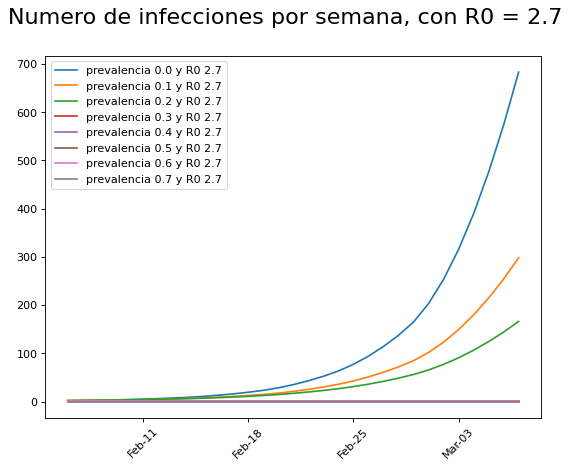

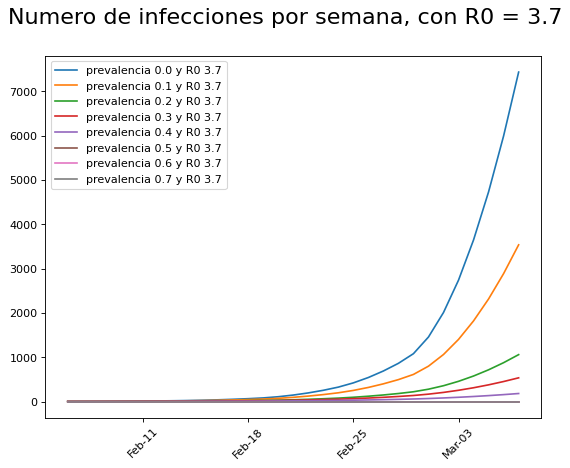

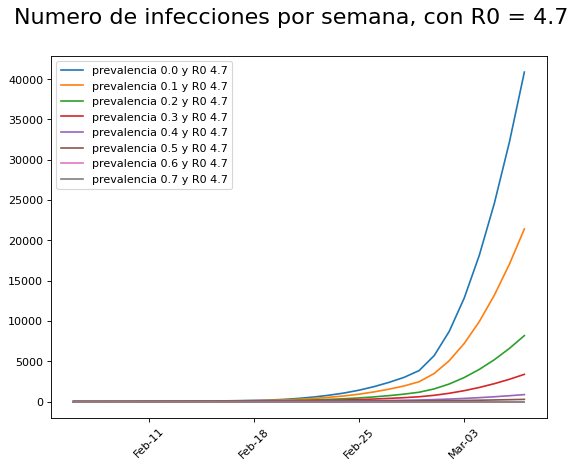

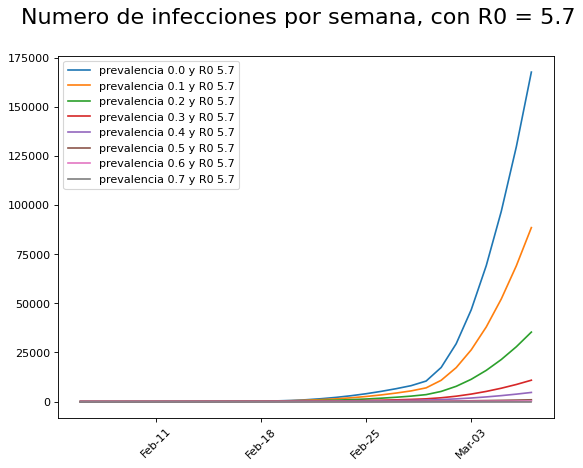

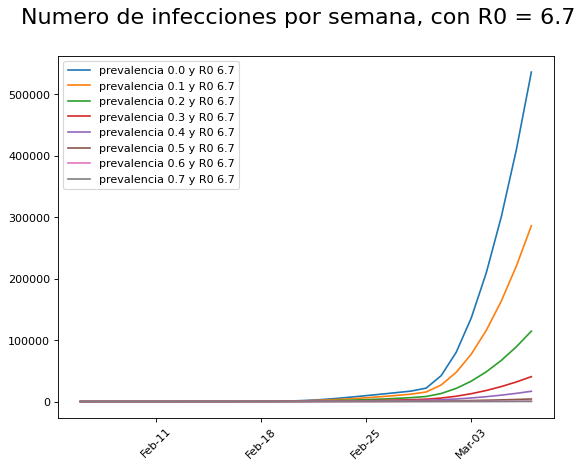

In [7]:
from IPython.display import display, HTML

ARRAY_R0S = [2.7,
             3.7 ,
             4.7,
             5.7,
             6.7 ]

for R0 in ARRAY_R0S : 
    print("Tabla de como varía el nº de infectados, según varía la prevalencia, con R0 = " + str(R0))
    df =  Calcular_Cuadro_Prevalencias(R0=R0,GENERACIONES=GENERACIONES,ARRAY_PREVALENCIAS=ARRAY_PREVALENCIAS)
    display(HTML (df.to_html()))
    plt = Get_Chart(df=interpolate_dataframe(df,'D'), title = 'Numero de infecciones por semana, con R0 = ' + str(R0))



TODO: 
    - Hacer gráfico de la evolución del nº de infectados, en el confinamiento (R0<1)
    

# Conclusiones:

- Para un R0 estimado de 5.7 del COVID-19, hace falta un <strong>70% de prevalencia</strong>, para que no haya brotes masivos.


- Las <strong>medidas de distanciamiento social</strong>, influyen para mantener bajo el R0, el cual influye mucho en el número de infectados.

    
- Con <strong>prevalencia bajas</strong>, aunque no haya inmunidad de grupo, el <strong>nº de infectados desciende significativamente</strong>. (En España, que los estudios sugieren una prevalencia menor del 10%, podría haber 1/3 ó 1/2 muertos)


- Además de la prevalencia, tambien <strong>es importante</strong>, tener controlado <strong>,el nº de personas infectadas en cada momento</strong>:
  - Hay que <strong>detectar los brotes lo mas pronto posible</strong>, y reducir el R0 mediante la <strong>búsqueda de contactos del infectado</strong> cuando el brote es aún pequeño. 
  - En caso contrario, si no se puede controlar el brote, como el nº de infectados se disparará, se pueden realizar <strong>confinamientos parciales intermitentes</strong>, para reducir el R0 por debajo de 1, hasta que el nº de infectados baje. 



## Bonus : ¿ Sirve de algo quedarse en casa  ? 
    

Tabla de como varía el nº de infectados, según varía el R0 


,prevalencia 0.0 y R0 2.7,prevalencia 0.0 y R0 3.7,prevalencia 0.0 y R0 4.7,prevalencia 0.0 y R0 5.7,prevalencia 0.0 y R0 6.7
2020-02-06,2,3,4,5,6
2020-02-11,5,11,18,28,40
2020-02-16,13,40,84,159,267
2020-02-21,35,147,394,906,1788
2020-02-26,94,543,1851,5164,11979
2020-03-02,253,2009,8699,29430,80234
2020-03-07,683,7432,40875,167617,536441


Total de infectados en cada escenario : 
prevalencia 0.0 y R0 2.7      1085
prevalencia 0.0 y R0 3.7     10185
prevalencia 0.0 y R0 4.7     51925
prevalencia 0.0 y R0 5.7    203309
prevalencia 0.0 y R0 6.7    630755
dtype: int64


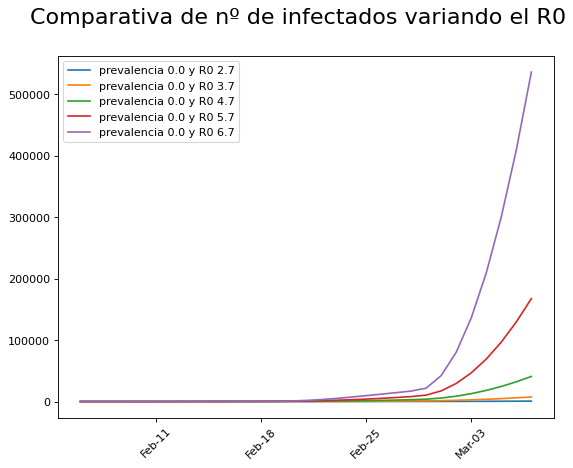

In [8]:

ARRAY_R0S = [2.7,
             3.7 ,
             4.7,
             5.7,
             6.7 ]

df_R0s = pd.DataFrame()

for MI_R0 in ARRAY_R0S : 
    df =  Calcular_Cuadro_Prevalencias(R0=MI_R0,GENERACIONES=GENERACIONES,ARRAY_PREVALENCIAS=ARRAY_PREVALENCIAS)
    df_R0s[df.columns[0]] = df[df.columns[0]]


print("Tabla de como varía el nº de infectados, según varía el R0 " )

    
display(HTML (df_R0s.to_html()))
print("Total de infectados en cada escenario : " )
print( df_R0s.astype(np.int64).sum(axis=0) )


plt = Get_Chart(interpolate_dataframe(df_R0s,'D') ,title= 'Comparativa de nº de infectados variando el R0')   



Como se ve en la gráfica, bajar el R0, es muy importante, para detener el nº de infectados, y por ende en número de los fallecidos.


## Re- Bonus : Se me ha hecho larguísimo, ¿ Podría haber estado menos tiempo en casa  ? 


In [9]:
def comparacion_semanas(SITUACION_INICIAL=1):
    GENERACIONES=8
    prevalencia=0
    diccionario_prevalencias={}
    R0=5.7
    i=1
    for NUM_GENERACIONES in range(5,8) : 
        infectados_en_esta_generacion=SITUACION_INICIAL
        array = []
        for generacion in  range(1,NUM_GENERACIONES):
            infectados_en_esta_generacion = infectados_en_esta_generacion * R0 * (1-prevalencia)
            array.append(infectados_en_esta_generacion)
        valor_actual = array[-1]
        # Calculamos el R0 con el confinamiento
        # En alemanio confinada el R0 estimado es un 0.7. Nosotros debería ser mas bajo
        NUEVO_R0 = 0.5
        while infectados_en_esta_generacion > 1 :
            infectados_en_esta_generacion = infectados_en_esta_generacion * NUEVO_R0 * (1-prevalencia)
            array.append(infectados_en_esta_generacion)
        diccionario_prevalencias[' R0 ' + str(R0) + ', parando en la semana ' + str(generacion)] = array
        i=1


    df = pd.DataFrame.from_dict(diccionario_prevalencias,'index')    
    df = Get_Header(df.shape[1]+1,df)
    df = df.T
    df.index = pd.to_datetime(df.index)

    return df 


Total de infectados en cada escenario : 
 R0 5.7, parando en la semana 4     140064
 R0 5.7, parando en la semana 5     798759
 R0 5.7, parando en la semana 6    4553312
dtype: int64
Tabla de como varía el nº de infectados, según varía la semana de inicio del confinamiento 


,"R0 5.7, parando en la semana 4","R0 5.7, parando en la semana 5","R0 5.7, parando en la semana 6"
2020-02-06 00:00:00,342,342,342
2020-02-11 00:00:00,"1,949","1,949","1,949"
2020-02-16 00:00:00,"11,112","11,112","11,112"
2020-02-21 00:00:00,"63,336","63,336","63,336"
2020-02-26 00:00:00,"31,668","361,015","361,015"
2020-03-02 00:00:00,"15,834","180,508","2,057,787"
2020-03-07 00:00:00,"7,917","90,254","1,028,893"
2020-03-12 00:00:00,"3,959","45,127","514,447"
2020-03-17 00:00:00,"1,979","22,563","257,223"
2020-03-22 00:00:00,990,"11,282","128,612"


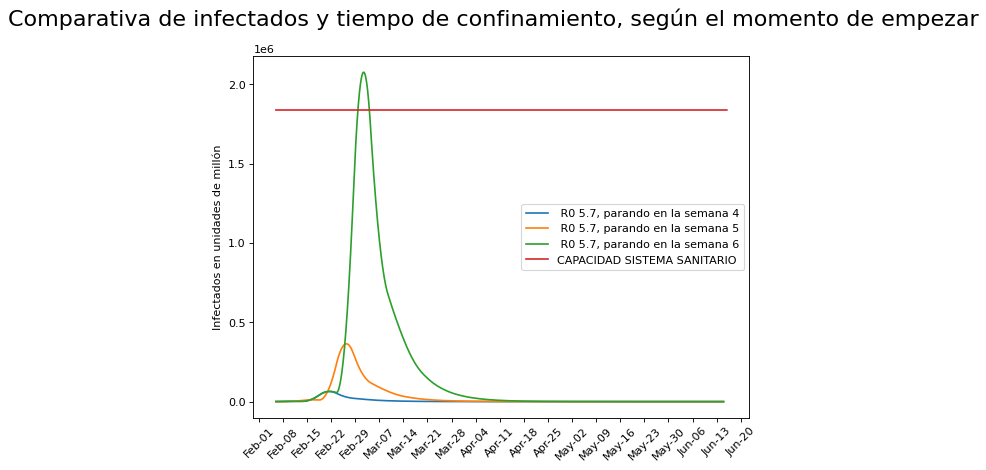

In [10]:

df = comparacion_semanas(SITUACION_INICIAL=60)
df= df.fillna(0)

print("Total de infectados en cada escenario : " )
print( df.astype(np.int64).sum(axis=0) )
df_interpolate = interpolate_dataframe(df=df,freq='H')
df_interpolate['CAPACIDAD SISTEMA SANITARIO' ] = CAPACIDAD_SISTEMA_SANITARIO

plt = Get_Chart(df = df_interpolate,title= 'Comparativa de infectados y tiempo de confinamiento, según el momento de empezar')  
plt.ylabel('Infectados en unidades de millón', size = 10)



print("Tabla de como varía el nº de infectados, según varía la semana de inicio del confinamiento " )
df.style.format ({ c : "{:20,.0f}" for c in df.columns }).background_gradient(cmap='Wistia',  )



Como se ve en del anterior gráfico, el tiempo que dura confinamiento, y el nº de infectados varía enormemente. 

Sin duda la demora en adoptar las restricciones - como se ve con esta gráfica de datos teóricos- ha influido en el tiempo de confinamiento, y mucho peor, ha costado un gran número de vidas.




## ¿ Se acabará la pandemia en verano ? 


Total de infectados en cada escenario : 
Ejemplo de si salieramos todos del estado de alarma 
Infectividad primera ola , R0=5.7                           223192
lo anterior + prevalencia actual , R0=5.13                  166334
lo anterior + distanciamiento social efectivo , R0=3.590     62751
lo anterior + uso mascarillas , R0=2.082                     15447
lo anterior + temperaturas de verano , R0=1.707               9599
lo anterior + confinamiento , R0=0.5                           873
dtype: int64


,"Infectividad primera ola , R0=5.7","lo anterior + prevalencia actual , R0=5.13","lo anterior + distanciamiento social efectivo , R0=3.590","lo anterior + uso mascarillas , R0=2.082","lo anterior + temperaturas de verano , R0=1.707","lo anterior + confinamiento , R0=0.5"
2020-07-06 00:00:00,"5,700","5,130","3,590","2,082","1,707",500
2020-07-11 00:00:00,"32,485","26,313","12,890","4,336","2,915",249
2020-07-16 00:00:00,"185,007","134,891","46,271","9,029","4,977",124


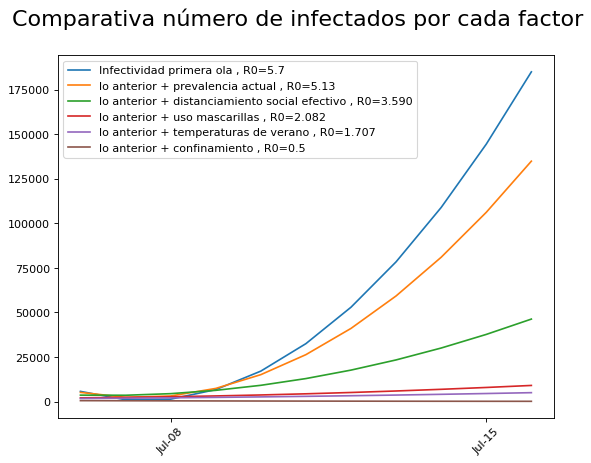

In [11]:
import numpy as np

### Aqui
INFECTIVIDAD_POR_DEFECTO = 5.7

ARRAY_R0S = [INFECTIVIDAD_POR_DEFECTO]
infectividad = INFECTIVIDAD_POR_DEFECTO
ARRAY_R0S_TITULOS = ["Infectividad primera ola"]



prevalencia = 0.1 
infectividad *= 1 - prevalencia 
ARRAY_R0S.append(infectividad)
ARRAY_R0S_TITULOS.append("lo anterior + prevalencia actual")

""" We simulated social distancing by reducing R0
by a fixed proportion, which ranged between 0 and 60%, on par with the reduction in R0
achieved in China through intense social distancing measures

""" 
distanciamiento_social_efectivo = 0.3
infectividad *= 1 - distanciamiento_social_efectivo 
ARRAY_R0S.append(infectividad)
ARRAY_R0S_TITULOS.append("lo anterior + distanciamiento social efectivo")
""" 
  Uso de mascarillas 
  The team investigated the varying effectiveness of facemasks. Previous research shows that even homemade masks made from cotton t-shirts or dishcloths can prove 90% effective at preventing transmission.
  The study suggests that an entire population wearing masks of just 75% effectiveness can bring a very high 'R' number of 4.0—the UK was close to this before lockdown—all the way down to under 1.0, even without aid of lockdowns.
  https://medicalxpress.com/news/2020-06-widespread-facemask-covid-.html
"""
porcentaje_efectividad_mascarillas = 0.7
porcentaje_poblacion_usa_mascarillas = 0.6
infectividad *= 1 - (porcentaje_efectividad_mascarillas * porcentaje_poblacion_usa_mascarillas)
ARRAY_R0S.append(infectividad)
ARRAY_R0S_TITULOS.append("lo anterior + uso mascarillas")

incremento_grados_temperatura_media = 15
infectividad_verano = 1 - ( incremento_grados_temperatura_media * 0.012 )
infectividad *= infectividad_verano
ARRAY_R0S.append(infectividad)
ARRAY_R0S_TITULOS.append("lo anterior + temperaturas de verano")

"""
  Confinamiento : 
  One study from France estimated that timely lockdowns pushed R0 down to 0.5 from 3.3
  https://hal-pasteur.archives-ouvertes.fr/pasteur-02548181/document
  
"""
#efectividad_confinamiento=0.88
#infectividad_confinamiento = 1 - ( efectividad_confinamiento )
#infectividad *= infectividad_confinamiento
infectividad = 0.5
ARRAY_R0S.append(infectividad)
ARRAY_R0S_TITULOS.append("lo anterior + confinamiento")

ARRAY_TITULOS = []
for i,element in enumerate(ARRAY_R0S):
    titulo = str(ARRAY_R0S_TITULOS[i]) + " , R0=" + str(ARRAY_R0S[i])[0:5]
    ARRAY_TITULOS.append(titulo)


df_R0s = pd.DataFrame()

GENERACIONES=4 
SITUACION_INICIAL=1000
FECHA_INICIAL_STR = '2020-07-01'
for MI_R0 in ARRAY_R0S : 
    df =  Calcular_Cuadro_Prevalencias(
        SITUACION_INICIAL  = SITUACION_INICIAL, 
        R0                 = MI_R0,
        GENERACIONES       = GENERACIONES,
        ARRAY_PREVALENCIAS = ARRAY_PREVALENCIAS,
        FECHA_INICIAL_STR  = FECHA_INICIAL_STR
    )
    df_R0s[df.columns[0]]  = df[df.columns[0]]

df_R0s.columns = ARRAY_TITULOS

print("Total de infectados en cada escenario : " )
  


print("Ejemplo de si salieramos todos del estado de alarma " )

print( df_R0s.astype(np.int64).sum(axis=0) )

plt = Get_Chart(interpolate_dataframe(df_R0s,'D') ,title= 'Comparativa número de infectados por cada factor')   

df_R0s.style.format ({ c : "{:20,.0f}" for c in df_R0s.columns }).background_gradient(cmap='Wistia',  )




De los datos anteriores parece que <strong>la epidemia no se va a poder contener durante el verano</strong>, salvo que alguno de los factores esté minusvalorado : 

-  Que en la nueva normalidad este tan atemorizada que haya un distanciamento social muy efectivo, 

- Que use mascarillas la práctica totalidad de la población, o 

- Que el incremento de la radiación solar tenga mas incidencia que la estimada.

No obstante, aunque no se acabará en verano, podemos intentar estimar si habrá una segunda ola que necesite confinamiento en verano.



## ¿ Cuándo llegará la segunda ola ? 

Para estimar si el sistema sanitario se verá sobrepasado otra vez, intentamos calcular la capacidad del sistema sanitario.
Sabieno el nº de camas UCIs, el porcentaje de hospitalizados que necesita una cama UCI, y el porcentaje de enfermos que necesitan hospitalización, estimamos la capacidad del sistema sanitario.

Estimación de cuando se supera la capacidad del sistema sanitario, en cada escenario
Presuponiendo una situación inicial de 1.000 infectados


,"Infectividad primera ola , R0=5.7","lo anterior + prevalencia actual , R0=5.13","lo anterior + distanciamiento social efectivo , R0=3.590","lo anterior + uso mascarillas , R0=2.082","lo anterior + temperaturas de verano , R0=1.707","lo anterior + confinamiento , R0=0.5"
2020-07-06,"5,700","5,130","3,590","2,082","1,707",500
2020-07-11,"32,485","26,313","12,890","4,336","2,915",249
2020-07-16,"185,007","134,891","46,271","9,029","4,977",124
2020-07-21,"1,049,309","689,433","165,927","18,798","8,498",61
2020-07-26,nan,"3,469,531","592,815","39,122","14,507",30
2020-07-31,nan,nan,"2,089,936","81,349","24,758",14
2020-08-05,nan,nan,nan,"168,849","42,229",6
2020-08-10,0,0,nan,"349,146","71,962",2
2020-08-15,0,0,nan,"716,323","122,433",0
2020-08-20,0,0,0,"1,445,890","207,734",0


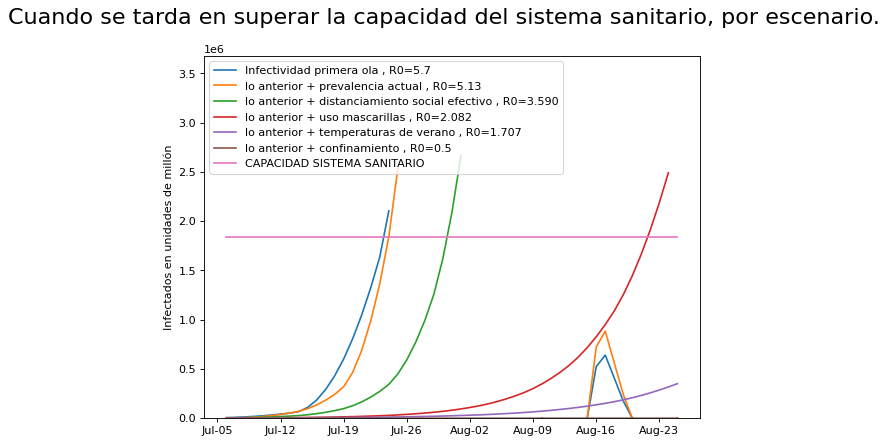

In [12]:

GENERACIONES=12
SITUACION_INICIAL=1000
FECHA_INICIAL_STR = '2020-07-01'
df_R0s = pd.DataFrame()

for MI_R0 in ARRAY_R0S : 
    df =  Calcular_Cuadro_Prevalencias(
        SITUACION_INICIAL  = SITUACION_INICIAL, 
        R0                 = MI_R0,
        GENERACIONES       = GENERACIONES,
        ARRAY_PREVALENCIAS = ARRAY_PREVALENCIAS,
        FECHA_INICIAL_STR  = FECHA_INICIAL_STR
    )
    df_R0s[df.columns[0]]  = df[df.columns[0]]
df_R0s.columns = ARRAY_TITULOS

df_master = df_R0s.copy()
df_R0s    = interpolate_dataframe(df_R0s,'D')
df_R0s    = df_R0s[df_R0s < (CAPACIDAD_SISTEMA_SANITARIO * 1.5) ]
df_R0s['CAPACIDAD SISTEMA SANITARIO' ] = CAPACIDAD_SISTEMA_SANITARIO

#plt = Get_Chart(df_R0s ,title= 'Comparativa número de infectados por cada factor')   
title = 'Cuando se tarda en superar la capacidad del sistema sanitario, por escenario.'
df    = df_R0s
fig   = plt.figure(figsize=(8, 6), dpi=80)
ax    = plt.gca()

ax.set_ylim([0,CAPACIDAD_SISTEMA_SANITARIO*2])

for ca in df.columns:
    plt.plot(df[ca])
    plt.legend(df.columns)
    fig.suptitle(title, fontsize=20)
#return plt
ax.legend(df.columns, loc='upper left')
plt.ylabel('Infectados en unidades de millón', size = 10)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt

print("Estimación de cuando se supera la capacidad del sistema sanitario, en cada escenario")
print("Presuponiendo una situación inicial de 1.000 infectados")

df_master
df_master = df_master[df_master < (CAPACIDAD_SISTEMA_SANITARIO * 2) ]

df_master.style.format ({ c : "{:20,.0f}" for c in df_master.columns }).background_gradient(cmap='Wistia',  )


### Conclusiones 

Estas son estimaciones, no datos reales, pero las tendencias son : 

- Parece que las <strong>temperaturas de verano</strong> pueden <strong>ralentizar la infección</strong> lo bastante como para que no tengamos otra ola hasta despues del verano.


- Tras el verano, <strong>futuras olas parecen inevitables</strong> en el plazo de <strong>entre un mes y dos</strong> de la finalización de las altas temperaturas.


- Habrá que adelantarse, con <strong>periodos de confinamientos intermitentes</strong>. La cantidad y duración de estos confinamientos aún deben estimarse.


- Futuros cambios de infectividad, o nuevos tratamientos podrían variar este escenario.




### Vamos a generar nuevas olas epidemicas, en cada escenario.

Las olas progresaran hasta que alcancen la capacidad del sistema sanitario, en cuyo caso habrá un confinamiento

TO-DO : Estimar mejor cuando se ocupan las camas uci (la duración de una estancia uci está entre 2-11 semanas)

TO-DO : Ajustar mejor los parámetros de mortalidad con saturación del sistema.




In [13]:
#### PRedicciones a futuro

"""
Crear 30.
Borrar las mayores de umbral superios.
Aplicar hasta que haya menos de x
"""
from datetime import date
RO_CALOR= 1.702             
GENERACIONES=9

def calcular_prevision(
    FECHA_FINAL_STR,
    FECHA_INICIAL_STR,
    SITUACION_INICIAL,
    POBLACION_INICIAL_INFECTADA,
    R0_max,
    R0_min,
    Umbral_max,
    Umbral_min):

    print(  FECHA_FINAL_STR,
    FECHA_INICIAL_STR,
    SITUACION_INICIAL,
    POBLACION_INICIAL_INFECTADA,
    R0_max,
    R0_min,
    Umbral_max,
    Umbral_min)
    df_temp = pd.DataFrame()
    df = pd.DataFrame(columns = ['Infectados'])    
    #
    while FECHA_INICIAL_STR < FECHA_FINAL_STR :

        df_temp = pd.DataFrame()
        PREVALENCIA = (POBLACION_INICIAL_INFECTADA + df.iloc[:,0].sum()) /45000000
        ARRAY_PREVALENCIAS = []
        ARRAY_PREVALENCIAS.append(PREVALENCIA)

        # Subida
        PERIODO_CALOR = ( FECHA_INICIAL_STR[5:] > '06-15' ) & ( FECHA_INICIAL_STR[5:] <  '09-15' )
        R0_DESCONTADO_CALOR = RO_CALOR if PERIODO_CALOR else R0_max
        print(f"""SITUACION_INICIAL={SITUACION_INICIAL},
            R0                 = {R0_DESCONTADO_CALOR} ,
            GENERACIONES       = {GENERACIONES}        ,
            ARRAY_PREVALENCIAS = {ARRAY_PREVALENCIAS}  ,
            FECHA_INICIAL_STR  = {FECHA_INICIAL_STR}""")
        
        df_temp =  Calcular_Cuadro_Prevalencias( SITUACION_INICIAL  = SITUACION_INICIAL   ,
            R0                 = R0_DESCONTADO_CALOR ,
            GENERACIONES       = GENERACIONES        ,
            ARRAY_PREVALENCIAS = ARRAY_PREVALENCIAS  ,
            FECHA_INICIAL_STR  = FECHA_INICIAL_STR )

        df_temp['Infectados'] = df_temp.iloc[:,0]
        df_temp = df_temp[(df_temp['Infectados'] < Umbral_max )]
        df_temp = df_temp[(df_temp['Infectados'] != 0 )]

        df_temp.dropna()
        df_temp = df_temp.loc[~df_temp.index.duplicated(keep='last')]
        df_temp = df_temp['Infectados'] 

        
        df_temp = pd.DataFrame(df_temp)
        df = pd.concat([df_temp,df])
        df = df.sort_index()

        # BAJADA TODO
        
        # Bajada
        PREVALENCIA = (POBLACION_INICIAL_INFECTADA + df.iloc[:,0].sum()) /45000000

        ARRAY_PREVALENCIAS = []
        ARRAY_PREVALENCIAS.append(PREVALENCIA)

        SITUACION_INICIAL = df.iloc[-1]['Infectados']
        FECHA_INICIAL_STR = df.index[-1]
        df_temp = pd.DataFrame()

        df_temp =  Calcular_Cuadro_Prevalencias(
            SITUACION_INICIAL=SITUACION_INICIAL,
            R0=R0_min,
            GENERACIONES=40,
            ARRAY_PREVALENCIAS=ARRAY_PREVALENCIAS,
            FECHA_INICIAL_STR  = FECHA_INICIAL_STR )

        df_temp['Infectados'] = df_temp.iloc[:,0]
        df_temp = df_temp[(df_temp['Infectados'] > Umbral_min)]
        df_temp = df_temp[(df_temp['Infectados'] != 0 )]
        df_temp.dropna()
        df_temp = df_temp.loc[~df_temp.index.duplicated(keep='last')]
        df_temp = df_temp['Infectados'] 
        
        
        df_temp = pd.DataFrame(df_temp)
        df = pd.concat([df_temp,df])
        df = df.sort_index()

        SITUACION_INICIAL = df.iloc[-1]['Infectados']
        FECHA_INICIAL_STR = df.index[-1]
        
    df = df.dropna()
    df = df.loc[~df.index.duplicated(keep='last')]

    return df

SITUACION_INICIAL           = 1000
POBLACION_INICIAL_INFECTADA = 4500000
R0_max                      = 5.7 
R0_min                      = 0.5
Umbral_max                  = CAPACIDAD_SISTEMA_SANITARIO 
Umbral_min                  = 10000
FECHA_INICIAL_STR           = '2020-07-01'
FECHA_FINAL_STR             = '2021-01-01'



df = calcular_prevision(
    FECHA_FINAL_STR,
    FECHA_INICIAL_STR,
    SITUACION_INICIAL,
    POBLACION_INICIAL_INFECTADA,
    R0_max,
    R0_min,
    Umbral_max,
    Umbral_min)
df                        
    

2021-01-01 2020-07-01 1000 4500000 5.7 0.5 1839090 10000
SITUACION_INICIAL=1000,
            R0                 = 1.702 ,
            GENERACIONES       = 9        ,
            ARRAY_PREVALENCIAS = [0.1]  ,
            FECHA_INICIAL_STR  = 2020-07-01
SITUACION_INICIAL=13552,
            R0                 = 1.702 ,
            GENERACIONES       = 9        ,
            ARRAY_PREVALENCIAS = [0.1021718888888889]  ,
            FECHA_INICIAL_STR  = 2020-08-15
SITUACION_INICIAL=13769,
            R0                 = 5.7 ,
            GENERACIONES       = 9        ,
            ARRAY_PREVALENCIAS = [0.13294224444444444]  ,
            FECHA_INICIAL_STR  = 2020-10-14
SITUACION_INICIAL=17321,
            R0                 = 5.7 ,
            GENERACIONES       = 9        ,
            ARRAY_PREVALENCIAS = [0.2032117111111111]  ,
            FECHA_INICIAL_STR  = 2020-11-23


,Infectados
2020-07-06,1531
2020-07-11,2345
2020-07-16,3591
2020-07-21,5499
2020-07-26,8420
2020-07-31,12890
2020-08-05,19728
2020-08-10,30179
2020-08-15,13552
2020-08-20,20708


2021-07-01 2020-07-01 10000 0 5.7 0.5 1839090 5000
SITUACION_INICIAL=10000,
            R0                 = 1.702 ,
            GENERACIONES       = 9        ,
            ARRAY_PREVALENCIAS = [0.0]  ,
            FECHA_INICIAL_STR  = 2020-07-01
SITUACION_INICIAL=7912,
            R0                 = 1.702 ,
            GENERACIONES       = 9        ,
            ARRAY_PREVALENCIAS = [0.049872955555555556]  ,
            FECHA_INICIAL_STR  = 2020-09-09
SITUACION_INICIAL=7585,
            R0                 = 5.7 ,
            GENERACIONES       = 9        ,
            ARRAY_PREVALENCIAS = [0.07729586666666667]  ,
            FECHA_INICIAL_STR  = 2020-11-13
SITUACION_INICIAL=7902,
            R0                 = 5.7 ,
            GENERACIONES       = 9        ,
            ARRAY_PREVALENCIAS = [0.12645424444444445]  ,
            FECHA_INICIAL_STR  = 2020-12-28
SITUACION_INICIAL=5150,
            R0                 = 5.7 ,
            GENERACIONES       = 9        ,
            ARRA

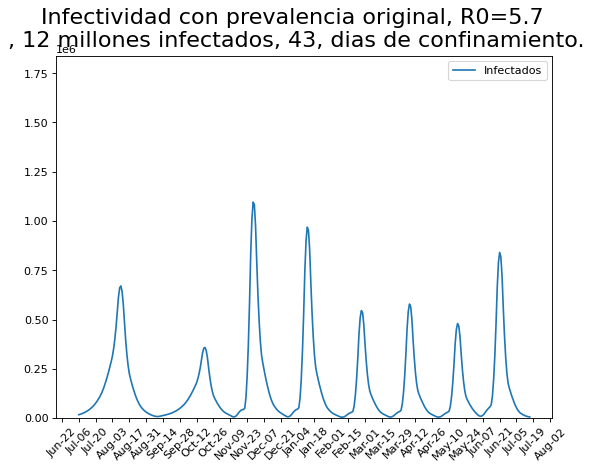

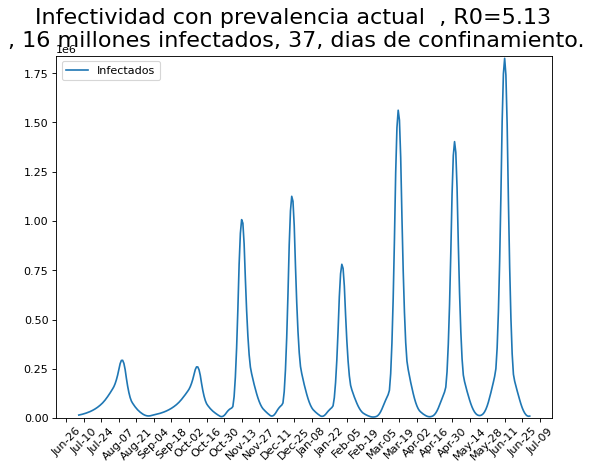

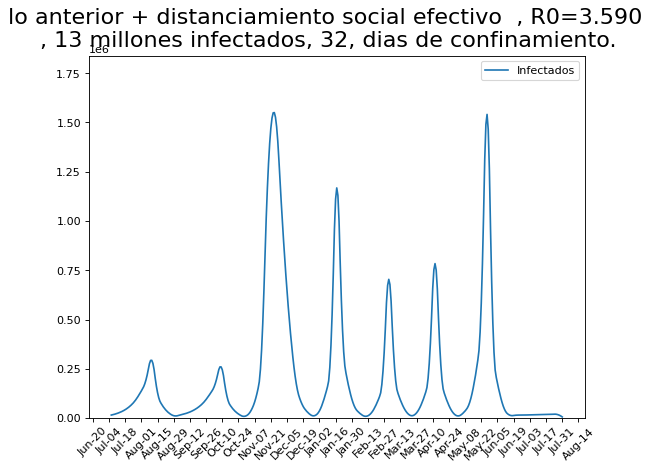

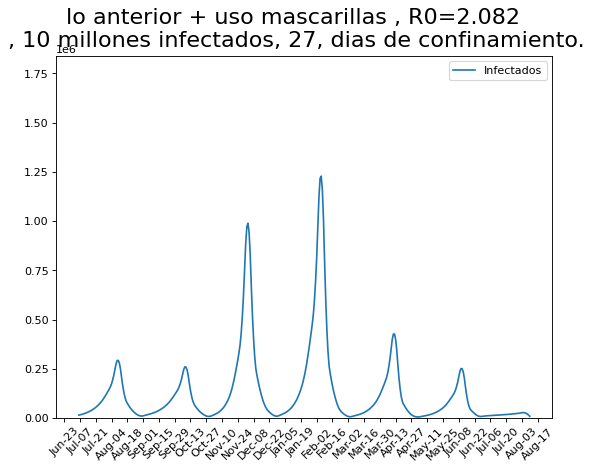

In [14]:
""" diccionario_R0s = {"Infectividad con prevalencia original, R0=5.7" : { R0 : 5.7, POBLACION_INICIAL_INFECTADA : 4500000} ,  
"lo anterior + distanciamiento social efectivo , R0=3.590"  : 3.590,   
"lo anterior + uso mascarillas , R0=2.082" : 2.082   ,                 
"lo anterior + temperaturas de verano , R0=1.707" : 1.702             
}

Infectividad primera ola , R0=5.7                           223383
lo anterior + distanciamiento social efectivo , R0=3.989     83430
lo anterior + uso mascarillas , R0=2.314                     20062
lo anterior + temperaturas de verano , R0=1.897              12331
lo anterior + confinamiento , R0=0.5                           875
"""
array_parametros = [
    { "descripcion" : "Infectividad con prevalencia original, R0=5.7"             , 'R0' : 5.7   , 'POBLACION_INICIAL_INFECTADA' : 0} ,
 ]
array_parametros = [
    { "descripcion" : "Infectividad con prevalencia original, R0=5.7"             , 'R0' : 5.7   , 'POBLACION_INICIAL_INFECTADA' : 0} ,
    { "descripcion" : "Infectividad con prevalencia actual  , R0=5.13"            , 'R0' : 5.7   , 'POBLACION_INICIAL_INFECTADA' : 4500000} ,
    { "descripcion" : "lo anterior + distanciamiento social efectivo  , R0=3.590" , 'R0' : 3.989 , 'POBLACION_INICIAL_INFECTADA' : 4500000} ,
    { "descripcion" : "lo anterior + uso mascarillas , R0=2.082"                  , 'R0' : 2.314 , 'POBLACION_INICIAL_INFECTADA' : 4500000} ,
]


df_array = []

dict_default_values = {
    "SITUACION_INICIAL" : 10000                        ,
    "R0_min"            :     0.5                      ,
    "Umbral_max"        :  CAPACIDAD_SISTEMA_SANITARIO , 
    "Umbral_min"        :  5000                        ,
    "FECHA_INICIAL_STR" : '2020-07-01'                 ,
    "FECHA_FINAL_STR"   : '2021-07-01'
}



for dict_escenario in array_parametros:
    ## Juntamos los valores por defecto, y los que cambian cada vez.
    param = {**dict_escenario, ** dict_default_values}
    #print(param)

    df_temp = pd.DataFrame()
    df_temp = calcular_prevision(
        FECHA_FINAL_STR             = param['FECHA_FINAL_STR'            ], 
        FECHA_INICIAL_STR           = param['FECHA_INICIAL_STR'          ], 
        SITUACION_INICIAL           = param['SITUACION_INICIAL'          ], 
        POBLACION_INICIAL_INFECTADA = param['POBLACION_INICIAL_INFECTADA'],
        R0_max                      = param['R0'                         ], 
        R0_min                      = param['R0_min'                     ], 
        Umbral_max                  = param['Umbral_max'                 ], 
        Umbral_min                  = param['Umbral_min'                 ]  
    )
    df_temp = df_temp.astype(np.int64)
    df_temp = df_temp.loc[~df_temp.index.duplicated(keep='last')]
    suma = int(df_temp.sum(axis=0)/1000000)    
    #print(param['descripcion'], df_temp.tail(1).index[-1],"suma: " , suma)
    df_array.append(df_temp) 
    DIAS_CONFINAMIENTO = df_temp.shape[0] - (df_temp['Infectados'] - df_temp['Infectados'].shift(1) > 0).sum()    
    plt = Get_Chart(df=interpolate_dataframe(df_temp,'D'), 
                    title = param['descripcion'] +" \n, "+ str(suma) + " millones infectados, " +  str(DIAS_CONFINAMIENTO) + ", dias de confinamiento." ) 
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))

    ax = plt.gca()
    ax.set_ylim([0,Umbral_max])
    param = {}
    
df  =  pd.concat(df_array)



In [15]:
"""Infectividad primera ola , R0=5.7                           int64
lo anterior + prevalencia actual , R0=5.13                  int64
lo anterior + distanciamiento social efectivo , R0=3.590    int64
lo anterior + uso mascarillas , R0=2.082                    int64
lo anterior + temperaturas de verano , R0=1.707             int64
lo anterior + confinamiento , R0=0.5                        int64
dtype: object
"""

'Infectividad primera ola , R0=5.7                           int64\nlo anterior + prevalencia actual , R0=5.13                  int64\nlo anterior + distanciamiento social efectivo , R0=3.590    int64\nlo anterior + uso mascarillas , R0=2.082                    int64\nlo anterior + temperaturas de verano , R0=1.707             int64\nlo anterior + confinamiento , R0=0.5                        int64\ndtype: object\n'

In [16]:
##### de aqui a abajo, solo debug

SITUACION_INICIAL=829339
R0                 = 5.7 
GENERACIONES       = 15        
ARRAY_PREVALENCIAS = [0.10]  
FECHA_INICIAL_STR  = '2020-10-04'
            
Calcular_Cuadro_Prevalencias( SITUACION_INICIAL  = SITUACION_INICIAL   ,
            R0                 = R0 ,
            GENERACIONES       = GENERACIONES        ,
            ARRAY_PREVALENCIAS = ARRAY_PREVALENCIAS  ,
            FECHA_INICIAL_STR  = FECHA_INICIAL_STR )

,prevalencia 0.1 y R0 5.7
2020-10-09,4254509
2020-10-14,19532857
2020-10-19,41349762
2020-10-24,0
2020-10-29,0
2020-11-03,0
2020-11-08,0
2020-11-13,0
2020-11-18,0
2020-11-23,0


In [17]:
df['incremento'] = df['Infectados'] - df['Infectados'].shift(1) > 0
df['incremento'].count()

306

In [18]:
kk = df.head(20)
kk['incremento'].sum()

13